In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor


from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import warnings

import pickle

sns.set()
warnings.filterwarnings('ignore')

from sklearn.feature_selection import mutual_info_regression, SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_percentage_error, mean_squared_error, roc_auc_score, log_loss, precision_recall_fscore_support, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from imblearn.over_sampling import RandomOverSampler, SMOTE

from pprint import pprint
import xgboost
from xgboost import XGBRegressor, XGBClassifier

from sklearn.tree import DecisionTreeClassifier

In [4]:
loan_df=pd.read_csv("loan_data_file.csv")
loan_df.head()

,Unnamed: 0,ListingKey,CreditGrade,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,...,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,date,year,month,ListingCategory,WageGroup
0,0,1021339766868145413AB3B,C,36,1,0.16516,0.1580,0.1380,0.13885,0.0724,...,1.0,0,0,0.0,258,2007-08-26,2007,8,Not Available,MediumWage
1,11,0F1734025150298088A5F2B,C,36,1,0.15033,0.1325,0.1225,0.11335,0.0724,...,1.0,0,0,0.0,53,2007-10-09,2007,10,Not Available,LowWage
2,12,0F1A3597143888805163EF7,Unknown,36,0,0.17969,0.1435,0.1335,0.12640,0.0524,...,1.0,0,0,0.0,1,2013-12-15,2013,12,Debt Consolidation,LowWage
3,15,0F483544120452347F48121,Unknown,36,0,0.35797,0.3177,0.3077,0.28960,0.1650,...,1.0,0,0,0.0,10,2012-04-10,2012,4,Household Expenses,MediumWage
4,21,1017340630713945364DA6B,D,36,1,0.21488,0.2075,0.1975,0.18835,0.0724,...,1.0,0,0,0.0,53,2007-11-30,2007,11,Not Available,MediumWage


In [5]:
loan_df.drop("Unnamed: 0",axis=1,inplace=True)

In [6]:
loan_df.isna().sum().value_counts()

0    70
dtype: int64

## Feature Engineering
***It's safe to drop the PercentFunded variable. BorrowerAPR and LenderYield are both versions of BorrowerRate, just with fees included, so they're unnecessary. occupation is a broad and hard to use column the estimation are unnecessary as it's our role to perform better than them***

In [7]:
loan_df.drop(["EstimatedEffectiveYield", "EstimatedLoss", "EstimatedReturn",
                  "Occupation", "CurrentlyInGroup", "GroupKey", "PercentFunded","ProsperRating (numeric)",
                  "Recommendations", "InvestmentFromFriendsCount", "InvestmentFromFriendsAmount",
                  "date" , "TotalProsperLoans","TotalProsperPaymentsBilled","OnTimeProsperPayments",
                  "ProsperPaymentsLessThanOneMonthLate","ProsperPaymentsOneMonthPlusLate","ProsperPrincipalBorrowed",
                  "ProsperPrincipalOutstanding","ListingKey","ListingCategory (numeric)","ListingCategory",
                'CurrentDelinquencies','AmountDelinquent','DelinquenciesLast7Years',"TradesOpenedLast6Months","PublicRecordsLast10Years","PublicRecordsLast12Months",
                ], axis=1,
                inplace=True)

loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49724 entries, 0 to 49723
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CreditGrade                         49724 non-null  object 
 1   Term                                49724 non-null  int64  
 2   LoanStatus                          49724 non-null  int64  
 3   BorrowerAPR                         49724 non-null  float64
 4   BorrowerRate                        49724 non-null  float64
 5   LenderYield                         49724 non-null  float64
 6   ProsperScore                        49724 non-null  int64  
 7   BorrowerState                       49724 non-null  object 
 8   EmploymentStatus                    49724 non-null  int64  
 9   IsBorrowerHomeowner                 49724 non-null  bool   
 10  CreditScore                         49724 non-null  float64
 11  FirstRecordedCreditLine             49724

In [8]:
#adjusting the data types
loan_df["IsBorrowerHomeowner"] = loan_df["IsBorrowerHomeowner"].astype(int)


loan_df["IsBorrowerHomeowner"][:10]

0    1
1    0
2    0
3    1
4    0
5    0
6    0
7    1
8    0
9    0
Name: IsBorrowerHomeowner, dtype: int32

In [9]:
first_credit_year = loan_df["FirstRecordedCreditLine"].str[:4]

loan_df["YearsWithCredit"] = 2014 - pd.to_numeric(first_credit_year)

loan_df.drop("FirstRecordedCreditLine", axis=1, inplace=True)

loan_df["YearsWithCredit"][:10]

0    13
1    14
2    18
3    15
4    11
5    16
6    39
7    14
8    26
9    11
Name: YearsWithCredit, dtype: int64

In [10]:
loan_df.drop(["BorrowerState"],inplace=True, axis=1)


In [11]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49724 entries, 0 to 49723
Data columns (total 41 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CreditGrade                         49724 non-null  object 
 1   Term                                49724 non-null  int64  
 2   LoanStatus                          49724 non-null  int64  
 3   BorrowerAPR                         49724 non-null  float64
 4   BorrowerRate                        49724 non-null  float64
 5   LenderYield                         49724 non-null  float64
 6   ProsperScore                        49724 non-null  int64  
 7   EmploymentStatus                    49724 non-null  int64  
 8   IsBorrowerHomeowner                 49724 non-null  int32  
 9   CreditScore                         49724 non-null  float64
 10  CurrentCreditLines                  49724 non-null  float64
 11  OpenCreditLines                     49724

In [12]:
state = pd.get_dummies(loan_df["WageGroup"])

loan_df = loan_df.join(state, rsuffix="_group")
loan_df.drop("WageGroup", axis=1, inplace=True)

loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49724 entries, 0 to 49723
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CreditGrade                         49724 non-null  object 
 1   Term                                49724 non-null  int64  
 2   LoanStatus                          49724 non-null  int64  
 3   BorrowerAPR                         49724 non-null  float64
 4   BorrowerRate                        49724 non-null  float64
 5   LenderYield                         49724 non-null  float64
 6   ProsperScore                        49724 non-null  int64  
 7   EmploymentStatus                    49724 non-null  int64  
 8   IsBorrowerHomeowner                 49724 non-null  int32  
 9   CreditScore                         49724 non-null  float64
 10  CurrentCreditLines                  49724 non-null  float64
 11  OpenCreditLines                     49724

In [13]:
loan_df.reset_index(drop=True, inplace=True)
loan_df[loan_df.select_dtypes(include='uint8').columns] = loan_df[loan_df.select_dtypes(include='uint8').columns].astype('int64')

In [14]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49724 entries, 0 to 49723
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CreditGrade                         49724 non-null  object 
 1   Term                                49724 non-null  int64  
 2   LoanStatus                          49724 non-null  int64  
 3   BorrowerAPR                         49724 non-null  float64
 4   BorrowerRate                        49724 non-null  float64
 5   LenderYield                         49724 non-null  float64
 6   ProsperScore                        49724 non-null  int64  
 7   EmploymentStatus                    49724 non-null  int64  
 8   IsBorrowerHomeowner                 49724 non-null  int32  
 9   CreditScore                         49724 non-null  float64
 10  CurrentCreditLines                  49724 non-null  float64
 11  OpenCreditLines                     49724

In [15]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
loan_df['CreditGrade']= label_encoder.fit_transform(loan_df['CreditGrade'])

In [16]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49724 entries, 0 to 49723
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   CreditGrade                         49724 non-null  int32  
 1   Term                                49724 non-null  int64  
 2   LoanStatus                          49724 non-null  int64  
 3   BorrowerAPR                         49724 non-null  float64
 4   BorrowerRate                        49724 non-null  float64
 5   LenderYield                         49724 non-null  float64
 6   ProsperScore                        49724 non-null  int64  
 7   EmploymentStatus                    49724 non-null  int64  
 8   IsBorrowerHomeowner                 49724 non-null  int32  
 9   CreditScore                         49724 non-null  float64
 10  CurrentCreditLines                  49724 non-null  float64
 11  OpenCreditLines                     49724

In [83]:
loan_df["CreditScore"].value_counts()

660.0    6095
680.0    6095
640.0    5938
700.0    5424
720.0    4918
740.0    3954
760.0    3153
620.0    2974
600.0    2602
780.0    2198
800.0    1332
520.0    1149
560.0     997
580.0     844
820.0     800
540.0     738
840.0     348
860.0     146
880.0      19
Name: CreditScore, dtype: int64

In [17]:
loan_df["LoanStatus"].value_counts()

1    33530
0    16194
Name: LoanStatus, dtype: int64

#### splitting the data into X and y

In [18]:
X=loan_df.drop("LoanStatus",axis=1)
y=loan_df["LoanStatus"]

In [19]:
X.head()

,CreditGrade,Term,BorrowerAPR,BorrowerRate,LenderYield,ProsperScore,EmploymentStatus,IsBorrowerHomeowner,CreditScore,CurrentCreditLines,...,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,Investors,year,month,YearsWithCredit,HighWage,LowWage,MediumWage
0,3,36,0.16516,0.1580,0.1380,5,1,1,640.0,5.0,...,0.00,0.00,0.0,258,2007,8,13,0,0,1
1,3,36,0.15033,0.1325,0.1225,5,1,0,640.0,2.0,...,0.00,0.00,0.0,53,2007,10,14,0,1,0
2,7,36,0.17969,0.1435,0.1335,4,1,0,680.0,9.0,...,0.00,0.00,0.0,1,2013,12,18,0,1,0
3,7,36,0.35797,0.3177,0.3077,5,0,1,700.0,10.0,...,3790.25,3790.25,0.0,10,2012,4,15,0,0,1
4,4,36,0.21488,0.2075,0.1975,5,1,0,620.0,4.0,...,0.00,0.00,0.0,53,2007,11,11,0,0,1


In [20]:
y.head()

0    1
1    1
2    0
3    0
4    1
Name: LoanStatus, dtype: int64

### Now we are going to preform the Scalling part in FE (Standarisation & Normalization)
### Feature Selection by using mutual_info_classi

In [21]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X, y)
mutual_info

array([1.23821900e-02, 1.52047030e-02, 5.55241691e-02, 5.33709703e-02,
       5.35651620e-02, 2.11176020e-02, 4.61011659e-03, 6.66552175e-03,
       1.89971839e-02, 3.24233060e-03, 5.86482294e-03, 0.00000000e+00,
       4.02569245e-03, 3.73426293e-03, 1.25511588e-02, 1.34242985e-02,
       0.00000000e+00, 1.07002036e-02, 1.07195518e-02, 1.37473478e-04,
       9.95533905e-03, 1.08947398e-02, 7.06261335e-03, 9.99013104e-03,
       1.54138872e-02, 4.44035087e-03, 4.92220720e-02, 1.91143362e-01,
       5.26491743e-01, 2.20793686e-02, 2.52244644e-02, 7.67005662e-02,
       4.54376867e-01, 4.45669653e-01, 6.46020640e-02, 5.87712328e-03,
       1.52327550e-02, 4.18548232e-03, 1.43110960e-04, 3.47966182e-03,
       2.47828733e-03, 6.56384647e-03])

In [22]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

LP_CustomerPrincipalPayments          0.526492
LP_GrossPrincipalLoss                 0.454377
LP_NetPrincipalLoss                   0.445670
LP_CustomerPayments                   0.191143
LP_CollectionFees                     0.076701
LP_NonPrincipalRecoverypayments       0.064602
BorrowerAPR                           0.055524
LenderYield                           0.053565
BorrowerRate                          0.053371
MonthlyLoanPayment                    0.049222
LP_ServiceFees                        0.025224
LP_InterestandFees                    0.022079
ProsperScore                          0.021118
CreditScore                           0.018997
LoanMonthsSinceOrigination            0.015414
year                                  0.015233
Term                                  0.015205
TotalInquiries                        0.013424
InquiriesLast6Months                  0.012551
CreditGrade                           0.012382
DebtToIncomeRatio                     0.010895
AvailableBank

<Axes: >

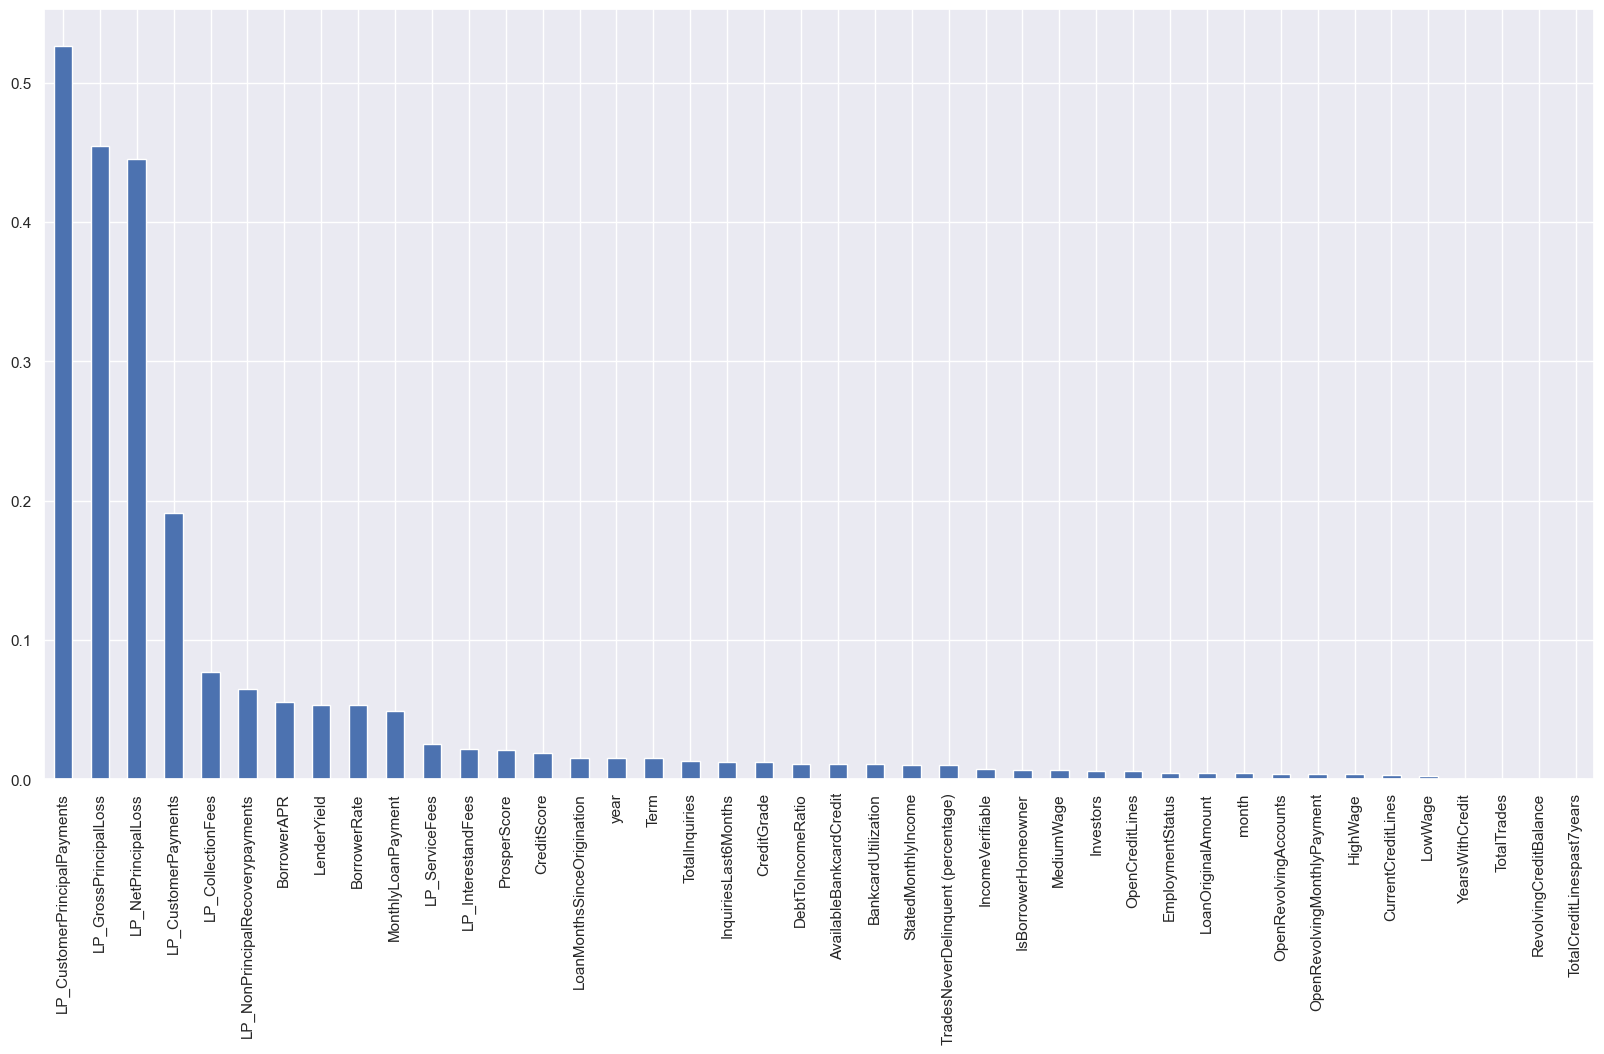

In [23]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 10))

In [87]:
mutual_info_classif

<function sklearn.feature_selection._mutual_info.mutual_info_classif(X, y, *, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)>

### 15 best Feature selection using by mutual_info_classif

In [24]:
from sklearn.feature_selection import SelectKBest

#Now we Will select the  top 15 important features

sel_five_cols = SelectKBest(mutual_info_classif, k=15)
sel_five_cols.fit(X, y)
selected_data=X.columns[sel_five_cols.get_support()]
selected_data

Index(['CreditGrade', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ProsperScore', 'CreditScore', 'MonthlyLoanPayment',
       'LP_CustomerPayments', 'LP_CustomerPrincipalPayments',
       'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees',
       'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments'],
      dtype='object')

In [25]:
X=X.loc[:,[ 'CreditGrade', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ProsperScore', 'CreditScore', 'MonthlyLoanPayment',
       'LP_CustomerPayments', 'LP_CustomerPrincipalPayments',
       'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees',
       'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments']]

In [84]:
X.head()

,CreditGrade,BorrowerAPR,BorrowerRate,LenderYield,ProsperScore,CreditScore,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments
0,0.428571,0.380025,0.438889,0.422857,0.4,0.333333,0.146759,0.280029,0.269286,0.126349,0.762903,1.0,0.003754,0.036778,0.0
1,0.428571,0.344497,0.368056,0.378571,0.4,0.333333,0.015017,0.024911,0.028571,0.000896,0.952736,1.0,0.003754,0.036778,0.0
2,1.000000,0.414834,0.398611,0.410000,0.3,0.444444,0.061021,0.003394,0.002533,0.003171,0.949120,1.0,0.003754,0.036778,0.0
3,1.000000,0.841934,0.882500,0.907714,0.4,0.500000,0.077153,0.012860,0.005993,0.020086,0.939922,1.0,0.154795,0.182812,0.0
4,0.571429,0.499138,0.576389,0.592857,0.4,0.277778,0.050029,0.099826,0.085714,0.068082,0.880648,1.0,0.003754,0.036778,0.0


### Handling imbalanced data

To reduce overfitting and underfitting problem.

Over Sampling minority class using Synthetic Minority Oversampling Technique (SMOTE)-In this method, synthetic samples are generated for the minority class and equal to the majority class

In [26]:
from imblearn.over_sampling import SMOTE 
smot = SMOTE(sampling_strategy='minority') 
X, y = smot.fit_resample(X, y) 
y.value_counts()

1    33530
0    33530
Name: LoanStatus, dtype: int64

In [27]:
# Normalization of X
X = (X - X.min()) / (X.max() - X.min())

In [28]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,0.406742,0.119378,-0.181609,0.154310,-0.137355,0.103375,0.016853,-0.005086,0.002569,-0.022888,-0.003582,-0.000656,-0.000380,0.016515,-1.952595e-15
1,0.403575,0.128769,-0.213605,-0.268732,-0.010492,0.059964,-0.005445,-0.002181,-0.007366,0.013446,0.006490,-0.000951,0.000445,-0.001046,2.785712e-16
2,0.052182,-0.262463,-0.084248,-0.260868,0.134540,0.265519,0.029709,0.031464,-0.007493,0.012296,0.001381,-0.002687,0.001279,-0.000894,1.005975e-15
3,-0.575426,0.029036,0.131128,-0.034831,0.141950,-0.108374,-0.030624,-0.000682,0.002603,-0.022924,0.004703,0.001146,-0.000836,0.000047,3.160192e-15
4,0.070664,0.142713,-0.192238,-0.076792,-0.081951,0.022044,0.019269,-0.011426,-0.005052,0.004199,-0.023321,-0.000327,0.000616,-0.002172,-1.559838e-15


In [29]:
data_load=pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)

data_load

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
CreditGrade,-0.517379,-0.761643,0.177828,-0.061619,0.000378,0.335751,0.028504,-0.033527,0.003004,0.022096,-0.040384,-0.000941,0.001576,-0.001624,4.316176e-17
BorrowerAPR,-0.449292,0.160672,-0.004337,0.140400,0.060913,-0.170569,-0.045894,0.196215,-0.002545,-0.119710,0.814988,-0.023048,0.001734,-0.010186,-1.698435e-15
BorrowerRate,-0.468280,0.222470,-0.006101,0.162176,0.007868,-0.228672,-0.018804,-0.084099,0.023890,-0.017475,-0.352560,0.005159,-0.009506,0.720980,-7.159240e-16
LenderYield,-0.478740,0.227174,-0.005185,0.171294,0.028251,-0.245390,-0.029812,-0.087207,0.005998,0.038880,-0.374725,0.020890,0.002974,-0.691312,2.147981e-15
ProsperScore,0.127231,-0.392859,0.128352,-0.077430,-0.465738,-0.764492,-0.052376,0.049034,-0.004486,-0.006376,0.020767,0.001955,-0.000663,-0.000547,-3.847738e-17
CreditScore,0.186952,-0.229896,0.259495,0.247025,0.815731,-0.335475,0.070086,-0.016794,0.007294,-0.010398,-0.017367,-0.002508,-0.001544,0.014571,-5.527036e-17
MonthlyLoanPayment,0.048820,0.013124,0.213953,0.263522,-0.078257,0.121151,-0.166536,0.880705,-0.055184,-0.076941,-0.221428,0.007002,0.001523,-0.000486,8.861250e-16
LP_CustomerPayments,0.104496,-0.077710,-0.022108,0.568007,-0.159830,0.092202,-0.155581,-0.196023,-0.034526,0.164637,0.068589,-0.006521,0.009732,0.006810,7.280506e-01
LP_CustomerPrincipalPayments,0.117787,-0.103633,-0.061802,0.534774,-0.125954,0.100394,-0.433634,-0.248542,0.082896,-0.093269,0.045671,0.012890,-0.010338,-0.002320,-6.260148e-01
LP_InterestandFees,0.008384,0.029707,0.080872,0.281927,-0.134285,0.015320,0.566238,0.046090,-0.275730,0.638050,0.076405,-0.045877,0.048527,0.022947,-2.793704e-01


In [30]:
# plot_variance(pca)

## Model Implementation

* Step 1: Splitting of the data first by using train and test split 

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.30, random_state=100)
print(X_pca.shape, X_train.shape, X_test.shape)

(67060, 15) (46942, 15) (20118, 15)


* Step 2 : Standarise the given data 

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

* Step 3: Model Implementation on the provided data 

### Gaussian Naive Baye's

In [33]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_std, Y_train)

GaussianNB()

In [34]:
Y_pred=gnb.predict(X_test_std)

In [35]:
from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(Y_test, Y_pred)*100)


Gaussian Naive Bayes model accuracy(in %): 70.09643105676508


In [36]:
#Evaluation of the model 

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.94      0.43      0.59     10030
           1       0.63      0.97      0.77     10088

    accuracy                           0.70     20118
   macro avg       0.78      0.70      0.68     20118
weighted avg       0.78      0.70      0.68     20118



In [37]:
confusion_matrix(Y_test,Y_pred)

array([[4297, 5733],
       [ 283, 9805]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

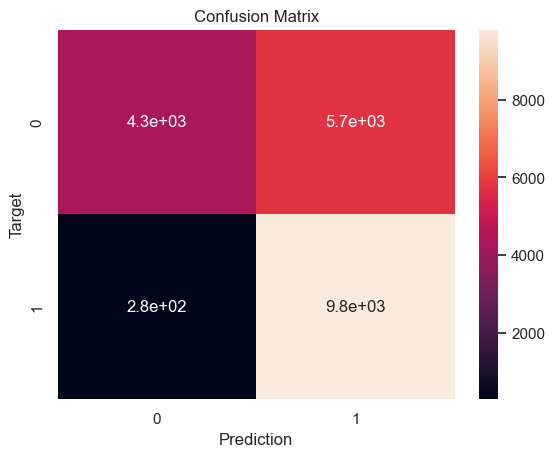

In [38]:
cf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure()
sns.heatmap(cf_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')
 
  

In [39]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import BernoulliNB

# mnb=MultinomialNB()
# mnb.fit(X_train_std,Y_train)

# we can't implement mnb because it can't handle the negative values

bnb=BernoulliNB()
bnb.fit(X_train_std,Y_train)

BernoulliNB()

In [40]:
Y_pred=bnb.predict(X_test_std)

In [41]:
from sklearn import metrics
print("Bernoulli Naive Bayes model accuracy(in %):", metrics.accuracy_score(Y_test, Y_pred)*100)


Bernoulli Naive Bayes model accuracy(in %): 79.87871557808927


In [42]:
#Evaluation of the model 

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79     10030
           1       0.78      0.83      0.81     10088

    accuracy                           0.80     20118
   macro avg       0.80      0.80      0.80     20118
weighted avg       0.80      0.80      0.80     20118



In [43]:
confusion_matrix(Y_test,Y_pred)

array([[7655, 2375],
       [1673, 8415]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix')

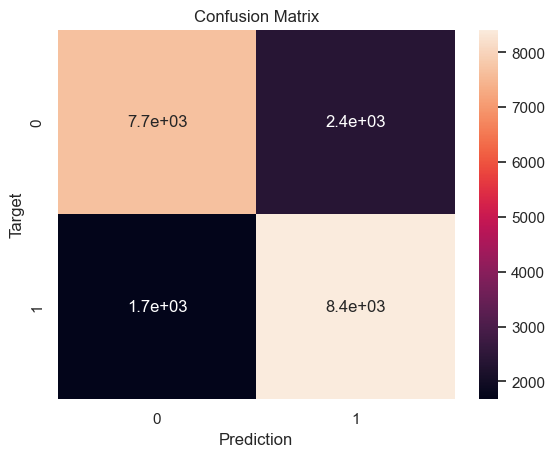

In [44]:
cf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure()
sns.heatmap(cf_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

## Logistic Regression Model 


In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
lgmodel=LogisticRegression()

In [47]:
lgmodel.fit(X_train_std,Y_train)

LogisticRegression()

In [48]:
y_pred=lgmodel.predict(X_test_std)

In [49]:
y_pred[:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [50]:
Y_test[:5]

47721    1
5067     0
59447    0
46473    1
65245    0
Name: LoanStatus, dtype: int64

## Evaluation

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     10030
           1       0.97      1.00      0.99     10088

    accuracy                           0.98     20118
   macro avg       0.99      0.98      0.98     20118
weighted avg       0.99      0.98      0.98     20118



In [53]:
accuracy = lgmodel.score(X_test_std, Y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9848891539914505


Text(0.5, 1.0, 'Confusion Matrix')

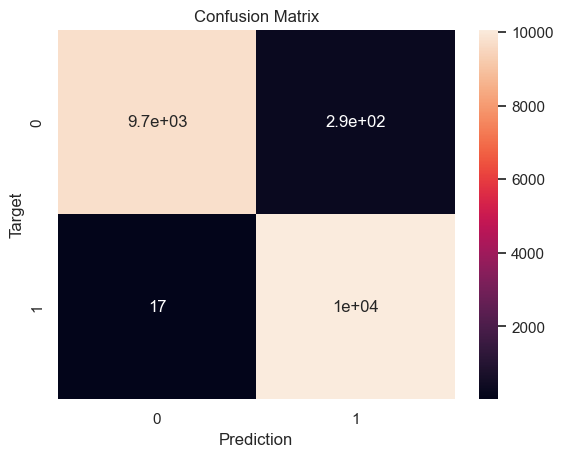

In [54]:
cf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure()
sns.heatmap(cf_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

## Pipeline for Naive Baye's Algorithm 

#### Importing of the libraries

In [55]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import BernoulliNB

from sklearn import set_config

In [56]:
# These are the estimators for the pipeline 
pca = PCA(n_components=15)
scaler = StandardScaler()

#this is the final estimator of my pipeline 
bnb=BernoulliNB()

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=100)

#### Creation of Pipe

In [58]:
naive_bayes_model_pipe=Pipeline([
    ("scaler",scaler),
    ("pca",pca),
    ("bnb",bnb)
])

In [59]:
set_config(display="diagram")

##### Structure of pipeline in diagramatic manner 

In [60]:
naive_bayes_model_pipe

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('bnb', BernoulliNB())])

****Fitting of the pipeline model****

In [61]:
naive_bayes_model_pipe.fit(X_train,Y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('bnb', BernoulliNB())])

In [62]:
Y_pred=naive_bayes_model_pipe.predict(X_test)

In [63]:
Y_test[:5]

47721    1
5067     0
59447    0
46473    1
65245    0
Name: LoanStatus, dtype: int64

In [64]:
Y_pred[:5]

array([1, 0, 1, 1, 0], dtype=int64)

In [65]:
print('test accuracy = ', round(accuracy_score(Y_test, Y_pred)*100, 2), '%')

test accuracy =  80.95 %


**The Accuracy of the Naive Baye's Model using Pipeline is 86.71%"**

In [66]:
print(classification_report(Y_test, Y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.826     0.782     0.804     10030
           1      0.794     0.836     0.815     10088

    accuracy                          0.809     20118
   macro avg      0.810     0.809     0.809     20118
weighted avg      0.810     0.809     0.809     20118



Text(0.5, 1.0, 'Confusion Matrix')

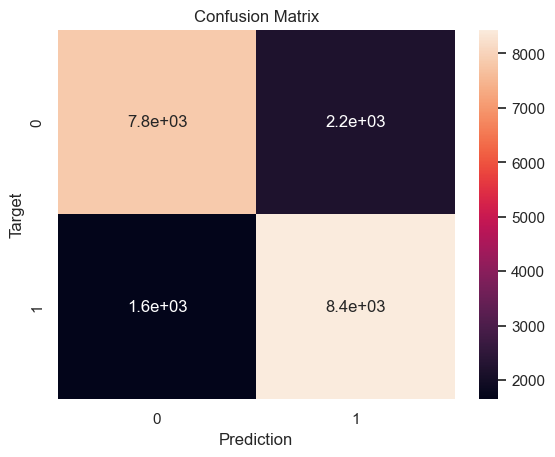

In [67]:
cf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure()
sns.heatmap(cf_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

## Pipeline for Logistic Regression Model

In [68]:
lg_model_pipeline=Pipeline([
    ("scaler",scaler),
    ("pca",pca),
    ("lgmodel",lgmodel)
])

In [69]:
lg_model_pipeline.fit(X_train,Y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('lgmodel', LogisticRegression())])

In [70]:
Y_predict=lg_model_pipeline.predict(X_test)

In [71]:
print('test accuracy = ', round(accuracy_score(Y_test, Y_predict)*100, 2), '%')

test accuracy =  98.56 %


***The Accuracy of the Logistic Regression Model using pipeline is 98.03%***

In [72]:
print(classification_report(Y_test, Y_predict, digits=3))

              precision    recall  f1-score   support

           0      0.998     0.973     0.985     10030
           1      0.974     0.998     0.986     10088

    accuracy                          0.986     20118
   macro avg      0.986     0.986     0.986     20118
weighted avg      0.986     0.986     0.986     20118



Text(0.5, 1.0, 'Confusion Matrix')

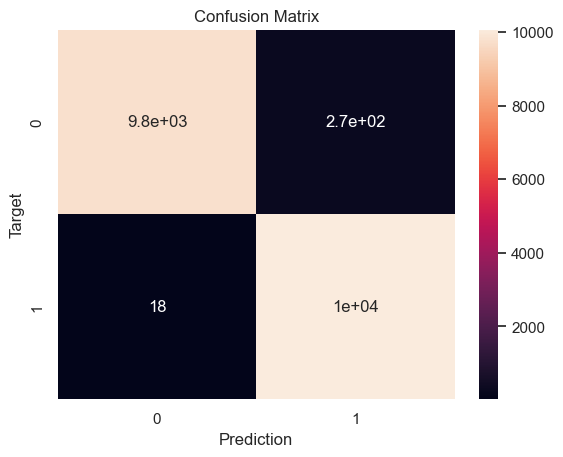

In [73]:
cf_matrix = confusion_matrix(Y_test, Y_predict)
plt.figure()
sns.heatmap(cf_matrix, annot=True)
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

# Final Classification Pipeline 

In [74]:
estimators = [('BNB', bnb),  ("logistic",lgmodel)]
clf = StackingClassifier(estimators=estimators)

In [75]:
classification_models = Pipeline([
    ('stdscaler', scaler),
    ('pca', pca),
    ('classifier', clf)
])

In [76]:
classification_models

Pipeline(steps=[('stdscaler', StandardScaler()), ('pca', PCA(n_components=15)),
                ('classifier',
                 StackingClassifier(estimators=[('BNB', BernoulliNB()),
                                                ('logistic',
                                                 LogisticRegression())]))])

In [77]:
classification_models.fit(X_train, Y_train)
pred = classification_models.predict(X_test)
print('test accuracy = ', round(accuracy_score(Y_test, pred)*100, 2), '%')

test accuracy =  98.9 %


In [78]:
print(classification_report(Y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.997     0.981     0.989     10030
           1      0.981     0.997     0.989     10088

    accuracy                          0.989     20118
   macro avg      0.989     0.989     0.989     20118
weighted avg      0.989     0.989     0.989     20118



## Creating a pickle file of final Classification model

* Importing pickle library

In [79]:
import pickle as pkl

In [80]:
pkl.dump(classification_models, open('cls_model_final.pkl', 'wb'))

### The classification model pipeline is converted into pickle file and dumped with the name as "cls_model_final"

In [81]:
import joblib

joblib.dump(classification_models,"classification_model.joblib")

['classification_model.joblib']